<a href="https://colab.research.google.com/github/Gityosan/google-colab/blob/main/step2-ver2-1-bertVevtors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### インストール・初期設定等

In [ ]:
!pip install -q transformers ipadic fugashi japanize_matplotlib
!pip install -q --upgrade 'matplotlib>=3.4'
!python -V
!rm -rf sample_data/
# matplotlib version 3.4以上確認
import matplotlib
print(matplotlib.__version__)
from google.colab import drive

drive.mount("/content/drive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 88.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.9/615.9 KB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 99.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 117.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 25.0 MB/s eta 0:00:00
Python 3.8.10
3.2.2


In [ ]:
# 標準ライブラリ
import gc
import glob
import json
import os
import pickle
import random
import re
import unicodedata

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import BertJapaneseTokenizer, BertModel

In [ ]:
# 前処理
def preprocessing(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[w/:%#$&?()~.=+-…]+[:]? ", "", text)
    text = re.sub(r"(^RT )", "", text)
    text = text.lower()  # 小文字化
    text = re.sub("\r", "", text)  # \r\nをdelete
    text = re.sub("\n", "", text)  # \r\nをdelete
    text = re.sub(r"\d+", "", text)  # 数字列をdelete
    ZEN = "".join(chr(0xFF01 + i) for i in range(94))  # 全角記号一覧
    HAN = "".join(chr(0x21 + i) for i in range(94))  # 半角記号一覧
    ETC = "".join(chr(0x3000 + i) for i in range(30))  # その他主要そうな記号
    text = text.translate(str.maketrans(ZEN, HAN))  # 全角記号を半角記号に置換
    FIXED_HAN = re.sub(r"[\w]+", "", HAN)
    return re.sub("[" + "~" + "*" + "＊" + ETC + FIXED_HAN + "]", " ", text)  # 記号を消す


# JSONからdf作成
def JSONtoDF(path):
    with open(path) as f:
        j = json.load(f)
        return pd.json_normalize(data=j["data"]).drop(
            ["created_at", "edit_history_tweet_ids"], axis=1
        )


# 上記2関数を組み合わせてcorpusを用意
def prepareCorpus(path_list):
    res = pd.DataFrame()
    for path in path_list:
        df = JSONtoDF(path)
        df["preprocessedText"] = [preprocessing(text) for text in df["text"]]
        res = pd.concat([res, df])
    return res.reset_index(drop=True)


def prepare_target_data(target_data_path=""):
    if not target_data_path or not os.path.exists("/content/" + target_data_path):
        print("Exit from function because the file doesn't exist")
        return
    with open(target_data_path) as f:
        target_data = json.load(f)
    target_keys = ["old", "new"]
    for key in target_data["data"]:
        item = target_data["data"][key]
        for target_key in target_keys:
            if not len([i["sentence"] for i in item[target_key]]):
                continue
            input = tokenizer(
                [unicodedata.normalize("NFC", i["sentence"]) for i in item[target_key]],
                return_tensors="pt",
                max_length=128,
                truncation=True,
                padding="max_length",
            )
            input = {k: v.to(device) for k, v in input.items()}
            outputs = model(**input)
            for i, v in zip(item[target_key], outputs.last_hidden_state):
                i["vector"] = torch.mean(v, 0).detach().tolist()
    with open(target_data_path, "w", encoding="utf-8") as f:
        json.dump(target_data, f, ensure_ascii=False)


def get_vectors(
    text_list=[],
    target_word=None,
    output_path=None,
    sequence_length=256,
    batch_size=512,
    layer_range=(0, 12),
):
    print("------------------------")

    # check params
    if not target_word or not output_path or not len(text_list):
        print("Exit from function due to improper parameters")
        return

    # check outputs
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
    if os.path.exists("/content/" + output_path):
        print("Exit from function because the file already exists")
        return

    print("Start process : get_vectors")

    # initialize
    vectors = []
    start_index = 0
    text_list = list(filter(lambda x: target_word in x, text_list))
    while start_index < len(text_list):
        input = tokenizer(
            text_list[start_index : start_index + batch_size],
            return_tensors="pt",
            max_length=sequence_length,
            truncation=True,
            padding="max_length",
        )
        input = {k: v.to(device) for k, v in input.items()}
        with torch.no_grad():
            outputs = model(**input, output_hidden_states=True)
            outputs_vectors = torch.mean(
                torch.stack(outputs.hidden_states[layer_range[0] : layer_range[1]]), 0
            )
            ids = tokenizer.encode(target_word)
            for i, v in tqdm(zip(input["input_ids"], outputs_vectors)):
                if ids[1] not in list(i):
                    continue
                pos = list(i).index(ids[1])
                vectors.append(
                    {
                        "position": (pos, pos + len(ids) - 2),
                        "vector": torch.mean(v, 0).detach().tolist(),
                    }
                )
        start_index += batch_size

    print("Finish process : {} / {}".format(target_word, len(vectors)))
    with open(output_path, "wb") as f:
        pickle.dump(vectors, f)


def compare_sentences(
    vectors_path="", target_data={}, target_word="", result_data_path="", year=""
):
    print("Start process : compare_sentences")
    with open(vectors_path, "rb") as f:
        vectors = pickle.load(f)
    with open(result_data_path) as f:
        result_data = json.load(f)
        result_data.setdefault("data",{})
        result_data["data"].setdefault(str(target_word),{})
        result_data["data"][target_word][str(year)] = {"total": 0, "old": 0, "new": 0}
    # 文章単位での判別
    item = result_data["data"][target_word][year]
    item["total"] = len(vectors)
    for v in vectors:
        similarity_to_old = torch.mean(
            torch.tensor(
                [
                    torch.cosine_similarity(
                        torch.tensor(v["vector"]), torch.tensor(old["vector"]), 0
                    )
                    for old in target_data["data"][target_word]["old"]
                ]
            ),
            0,
        )
        similarity_to_new = torch.mean(
            torch.tensor(
                [
                    torch.cosine_similarity(
                        torch.tensor(v["vector"]), torch.tensor(new["vector"]), 0
                    )
                    for new in target_data["data"][target_word]["new"]
                ]
            ),
            0,
        )
        if similarity_to_new <= similarity_to_old:
            item["old"] += 1
        else:
            item["new"] += 1
    print(
        "Finish process : {:.2%} / {:.2%}".format(
            item["old"] / item["total"], item["new"] / item["total"]
        )
    )
    with open(result_data_path, "w", encoding="utf-8") as f:
        json.dump(result_data, f, ensure_ascii=False)

In [ ]:
# @title  { vertical-output: true, form-width: "35%", display-mode: "both" }

# 初期設定群
base_dir = "drive/MyDrive/script/bert/"  # @param {type:"string"}
target = "cl-tohoku/bert-base-japanese-whole-word-masking"  # @param {type:"string"}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertJapaneseTokenizer.from_pretrained(target, tokenize_chinese_chars=False)
model = BertModel.from_pretrained(target).to(device)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 分散表現取得処理等

In [ ]:
with open(base_dir + "target_data.json", "r", encoding="utf-8") as f:
    target_data = json.load(f)

target_words = [unicodedata.normalize("NFC", w) for w in target_data["meta"]["target_words"]]

path_list = glob.glob(base_dir + "twitter-corpus/*.json")
path_list.sort()
oparation = [
    {
        "word": w,
        "year": y,
        "path_list": list(
            filter(
                lambda x: w in unicodedata.normalize("NFC", x) and str(y) in x,
                path_list,
            )
        ),
    }
    for w in target_words
    for y in range(2007, 2021)
]

In [ ]:
# target_dataの例文が変わる度にこのセルを実行する
prepare_target_data(base_dir + "target_data.json")

In [ ]:
# 分散表現を取得する
for o in oparation:
    if not len(o["path_list"]):
        print("Pass this loop due to empty of path_list")
        continue
    sequence_length = 200
    layer_range = (8, 12)
    target_word = unicodedata.normalize("NFC", o["word"])
    output_path = (
        base_dir
        + "word-vectors/"
        + str(sequence_length)
        + "-"
        + str(layer_range[0])
        + "-"
        + str(layer_range[1])
        + "/"
        + str(target_word)
        + "-"
        + str(o["year"])
        + ".pickle"
    )
    get_vectors(
        text_list=prepareCorpus(o["path_list"])["preprocessedText"].values.tolist(),
        target_word=target_word,
        output_path=output_path,
        sequence_length=sequence_length,
        batch_size=1000,
        layer_range=layer_range,
    )
    compare_sentences(
        vectors_path=output_path,
        target_data=target_data,
        target_word=unicodedata.normalize("NFC", o["word"]),
        result_data_path=base_dir+"result_data.json",
        year=str(o["year"])
    )

------------------------
Start process : get_vectors


1000it [00:03, 290.69it/s]
1000it [00:03, 292.97it/s]
840it [00:02, 291.70it/s]


Finish process : 失笑 / 2840
Start process : compare_sentences
Finish process : 61.97% / 38.03%
------------------------
Start process : get_vectors


1000it [00:03, 279.12it/s]
1000it [00:03, 283.75it/s]
1000it [00:03, 284.09it/s]
1000it [00:03, 284.51it/s]
907it [00:03, 282.72it/s]


Finish process : 失笑 / 4907
Start process : compare_sentences
Finish process : 71.98% / 28.02%
------------------------
Start process : get_vectors


1000it [00:03, 264.91it/s]
1000it [00:03, 270.67it/s]
1000it [00:03, 269.32it/s]
1000it [00:03, 272.37it/s]
1000it [00:03, 276.27it/s]
1000it [00:03, 284.53it/s]
1000it [00:03, 286.97it/s]
1000it [00:03, 285.00it/s]
1000it [00:03, 283.08it/s]
314it [00:01, 290.95it/s]


Finish process : 失笑 / 9314
Start process : compare_sentences
Finish process : 73.48% / 26.52%
------------------------
Start process : get_vectors


1000it [00:03, 266.58it/s]
1000it [00:03, 271.84it/s]
1000it [00:03, 268.49it/s]
1000it [00:03, 269.26it/s]
1000it [00:03, 269.14it/s]
1000it [00:03, 269.43it/s]
1000it [00:03, 262.50it/s]
1000it [00:03, 261.89it/s]
1000it [00:03, 262.15it/s]
903it [00:03, 259.47it/s]


Finish process : 失笑 / 9903
Start process : compare_sentences
Finish process : 71.94% / 28.06%
------------------------
Start process : get_vectors


1000it [00:03, 274.87it/s]
1000it [00:03, 275.50it/s]
1000it [00:03, 276.46it/s]
1000it [00:03, 276.82it/s]
1000it [00:03, 273.19it/s]
1000it [00:03, 278.15it/s]
1000it [00:03, 275.19it/s]
1000it [00:03, 277.12it/s]
1000it [00:03, 282.64it/s]
768it [00:02, 275.37it/s]


Finish process : 失笑 / 9768
Start process : compare_sentences
Finish process : 74.21% / 25.79%
------------------------
Start process : get_vectors


1000it [00:03, 277.47it/s]
1000it [00:03, 283.90it/s]
1000it [00:03, 294.37it/s]
1000it [00:03, 283.42it/s]
1000it [00:03, 281.68it/s]
1000it [00:03, 275.94it/s]
1000it [00:03, 274.70it/s]
1000it [00:03, 279.57it/s]
1000it [00:03, 267.71it/s]
615it [00:02, 283.27it/s]


Finish process : 失笑 / 9615
Start process : compare_sentences
Finish process : 72.73% / 27.27%
------------------------
Start process : get_vectors


1000it [00:03, 275.90it/s]
1000it [00:03, 274.75it/s]
1000it [00:03, 278.74it/s]
1000it [00:03, 277.62it/s]
1000it [00:03, 272.77it/s]
1000it [00:03, 279.35it/s]
1000it [00:03, 271.58it/s]
1000it [00:03, 273.10it/s]
1000it [00:03, 277.46it/s]
643it [00:02, 267.03it/s]


Finish process : 失笑 / 9641
Start process : compare_sentences
Finish process : 67.64% / 32.36%
------------------------
Start process : get_vectors


1000it [00:03, 258.41it/s]
1000it [00:04, 236.31it/s]
1000it [00:03, 251.04it/s]
1000it [00:04, 241.22it/s]
1000it [00:04, 238.10it/s]
1000it [00:04, 245.83it/s]
1000it [00:04, 233.65it/s]
1000it [00:03, 266.95it/s]
1000it [00:04, 243.93it/s]
800it [00:02, 269.52it/s]


Finish process : 失笑 / 9799
Start process : compare_sentences
Finish process : 72.11% / 27.89%
------------------------
Start process : get_vectors


1000it [00:03, 267.93it/s]
1000it [00:03, 271.12it/s]
1000it [00:03, 266.29it/s]
1000it [00:03, 260.29it/s]
1000it [00:03, 264.49it/s]
1000it [00:03, 251.44it/s]
1000it [00:03, 265.46it/s]
1000it [00:03, 266.49it/s]
1000it [00:03, 261.53it/s]
640it [00:02, 257.13it/s]


Finish process : 失笑 / 9640
Start process : compare_sentences
Finish process : 72.04% / 27.96%
------------------------
Start process : get_vectors


1000it [00:04, 249.83it/s]
1000it [00:03, 273.42it/s]
1000it [00:04, 248.53it/s]
1000it [00:03, 252.57it/s]
1000it [00:04, 249.21it/s]
1000it [00:04, 243.97it/s]
1000it [00:03, 257.60it/s]
1000it [00:03, 254.67it/s]
1000it [00:03, 258.12it/s]
633it [00:02, 253.69it/s]


Finish process : 失笑 / 9633
Start process : compare_sentences
Finish process : 75.08% / 24.92%
------------------------
Start process : get_vectors


1000it [00:03, 257.84it/s]
1000it [00:03, 252.68it/s]
1000it [00:04, 248.76it/s]
1000it [00:03, 266.75it/s]
1000it [00:03, 259.87it/s]
1000it [00:03, 266.69it/s]
1000it [00:03, 257.90it/s]
1000it [00:03, 254.90it/s]
1000it [00:04, 243.71it/s]
436it [00:01, 247.72it/s]


Finish process : 失笑 / 9436
Start process : compare_sentences
Finish process : 73.75% / 26.25%
------------------------
Start process : get_vectors


1000it [00:03, 252.98it/s]
1000it [00:03, 253.17it/s]
1000it [00:04, 245.21it/s]
1000it [00:04, 244.73it/s]
1000it [00:03, 263.80it/s]
1000it [00:03, 254.22it/s]
1000it [00:04, 240.22it/s]
127it [00:00, 240.71it/s]


Finish process : 失笑 / 7127
Start process : compare_sentences
Finish process : 76.89% / 23.11%
------------------------
Start process : get_vectors


1000it [00:03, 259.15it/s]
1000it [00:04, 237.40it/s]
1000it [00:04, 241.38it/s]
1000it [00:03, 257.15it/s]
1000it [00:03, 257.21it/s]
1000it [00:03, 262.46it/s]
1000it [00:03, 259.35it/s]
1000it [00:04, 230.74it/s]
1000it [00:04, 216.91it/s]
483it [00:01, 241.86it/s]


Finish process : 失笑 / 9483
Start process : compare_sentences
Finish process : 77.88% / 22.12%
------------------------
Start process : get_vectors


1000it [00:04, 229.26it/s]
1000it [00:04, 243.80it/s]
1000it [00:03, 250.71it/s]
1000it [00:03, 263.26it/s]
1000it [00:03, 269.35it/s]
1000it [00:03, 278.42it/s]
1000it [00:03, 267.92it/s]
1000it [00:04, 247.94it/s]
1000it [00:03, 252.53it/s]
241it [00:00, 249.33it/s]


Finish process : 失笑 / 9241
Start process : compare_sentences
Finish process : 66.92% / 33.08%
------------------------
Start process : get_vectors


840it [00:02, 300.28it/s]


Finish process : なし崩し / 840
Start process : compare_sentences
Finish process : 64.29% / 35.71%
------------------------
Start process : get_vectors


1000it [00:03, 286.41it/s]
1000it [00:03, 287.64it/s]
1000it [00:03, 290.90it/s]
120it [00:00, 294.26it/s]


Finish process : なし崩し / 3120
Start process : compare_sentences
Finish process : 62.18% / 37.82%
------------------------
Start process : get_vectors


1000it [00:03, 277.54it/s]
1000it [00:03, 289.50it/s]
1000it [00:03, 290.35it/s]
1000it [00:03, 291.36it/s]
1000it [00:03, 290.04it/s]
1000it [00:03, 289.07it/s]
1000it [00:03, 289.92it/s]
656it [00:02, 291.33it/s]


Finish process : なし崩し / 7656
Start process : compare_sentences
Finish process : 62.08% / 37.92%
------------------------
Start process : get_vectors


1000it [00:03, 264.42it/s]
1000it [00:03, 256.25it/s]
1000it [00:03, 251.31it/s]
1000it [00:03, 265.12it/s]
1000it [00:03, 263.64it/s]
1000it [00:03, 263.00it/s]
1000it [00:03, 258.18it/s]
1000it [00:03, 253.71it/s]
1000it [00:03, 261.29it/s]
807it [00:03, 263.08it/s]


Finish process : なし崩し / 9806
Start process : compare_sentences
Finish process : 69.52% / 30.48%
------------------------
Start process : get_vectors


1000it [00:03, 260.75it/s]
1000it [00:03, 262.25it/s]
1000it [00:03, 255.16it/s]
1000it [00:04, 245.64it/s]
1000it [00:04, 249.34it/s]
1000it [00:04, 241.06it/s]
1000it [00:03, 262.24it/s]
1000it [00:03, 254.91it/s]
1000it [00:04, 249.00it/s]
524it [00:02, 251.46it/s]


Finish process : なし崩し / 9524
Start process : compare_sentences
Finish process : 71.98% / 28.02%
------------------------
Start process : get_vectors


1000it [00:03, 262.69it/s]
1000it [00:04, 243.98it/s]
1000it [00:04, 246.45it/s]
1000it [00:03, 257.82it/s]
1000it [00:03, 260.44it/s]
1000it [00:03, 264.34it/s]
1000it [00:03, 266.89it/s]
1000it [00:04, 238.51it/s]
1000it [00:03, 256.09it/s]
619it [00:02, 264.49it/s]


Finish process : なし崩し / 9619
Start process : compare_sentences
Finish process : 70.60% / 29.40%
------------------------
Start process : get_vectors


1000it [00:04, 231.31it/s]
1000it [00:04, 228.05it/s]
1000it [00:04, 242.72it/s]
1000it [00:04, 229.67it/s]
1000it [00:04, 216.89it/s]
1000it [00:04, 240.33it/s]
1000it [00:03, 254.42it/s]
1000it [00:03, 283.66it/s]
1000it [00:03, 296.86it/s]
269it [00:00, 276.40it/s]


Finish process : なし崩し / 9269
Start process : compare_sentences
Finish process : 88.72% / 11.28%
------------------------
Start process : get_vectors


1000it [00:03, 268.63it/s]
1000it [00:03, 265.14it/s]
1000it [00:04, 239.80it/s]
1000it [00:03, 268.23it/s]
1000it [00:03, 261.78it/s]
1000it [00:03, 256.74it/s]
1000it [00:03, 259.61it/s]
1000it [00:03, 262.71it/s]
1000it [00:03, 251.23it/s]
673it [00:02, 262.07it/s]


Finish process : なし崩し / 9672
Start process : compare_sentences
Finish process : 76.67% / 23.33%
------------------------
Start process : get_vectors


1000it [00:04, 241.85it/s]
1000it [00:03, 253.70it/s]
1000it [00:03, 256.52it/s]
1000it [00:04, 247.29it/s]
1000it [00:04, 247.28it/s]
1000it [00:03, 257.84it/s]
1000it [00:04, 242.68it/s]
1000it [00:03, 262.90it/s]
884it [00:03, 241.31it/s]


Finish process : なし崩し / 8882
Start process : compare_sentences
Finish process : 71.97% / 28.03%
------------------------
Start process : get_vectors


1000it [00:04, 242.52it/s]
1000it [00:05, 195.88it/s]
1000it [00:04, 246.33it/s]
1000it [00:03, 254.76it/s]
1000it [00:03, 254.71it/s]
1000it [00:04, 236.00it/s]
1000it [00:03, 250.31it/s]
1000it [00:04, 245.70it/s]
866it [00:03, 256.92it/s]


Finish process : なし崩し / 8865
Start process : compare_sentences
Finish process : 66.05% / 33.95%
------------------------
Start process : get_vectors


1000it [00:03, 250.39it/s]
1000it [00:03, 267.83it/s]
1000it [00:04, 207.97it/s]
1000it [00:03, 254.77it/s]
1000it [00:03, 271.49it/s]
1000it [00:03, 314.73it/s]
1000it [00:03, 263.85it/s]
1000it [00:04, 234.70it/s]
307it [00:01, 263.05it/s]


Finish process : なし崩し / 8306
Start process : compare_sentences
Finish process : 79.33% / 20.67%
------------------------
Start process : get_vectors


1000it [00:04, 246.73it/s]
1000it [00:04, 236.04it/s]
1000it [00:04, 244.25it/s]
1000it [00:04, 241.60it/s]
1000it [00:03, 252.88it/s]
1000it [00:03, 250.74it/s]
1000it [00:04, 237.09it/s]
1000it [00:04, 209.09it/s]
1000it [00:04, 207.47it/s]
94it [00:00, 182.31it/s]


Finish process : なし崩し / 9094
Start process : compare_sentences
Finish process : 79.43% / 20.57%
------------------------
Start process : get_vectors


1000it [00:04, 242.28it/s]
1000it [00:04, 235.43it/s]
1000it [00:04, 225.68it/s]
1000it [00:04, 224.22it/s]
1000it [00:04, 231.25it/s]
1000it [00:04, 229.84it/s]
1000it [00:04, 239.11it/s]
1000it [00:04, 222.09it/s]
1000it [00:04, 238.53it/s]
690it [00:02, 246.06it/s]


Finish process : なし崩し / 9688
Start process : compare_sentences
Finish process : 90.92% / 9.08%
------------------------
Start process : get_vectors


1000it [00:04, 238.62it/s]
1000it [00:04, 229.55it/s]
1000it [00:04, 221.34it/s]
1000it [00:04, 246.32it/s]
1000it [00:04, 241.65it/s]
1000it [00:04, 239.71it/s]
1000it [00:04, 244.90it/s]
1000it [00:04, 231.02it/s]
1000it [00:04, 245.83it/s]
323it [00:01, 216.61it/s]


Finish process : なし崩し / 9322
Start process : compare_sentences
Finish process : 63.00% / 37.00%
------------------------
Start process : get_vectors


160it [00:00, 324.63it/s]


Finish process : なしくずし / 160
Start process : compare_sentences
Finish process : 100.00% / 0.00%
------------------------
Start process : get_vectors


860it [00:02, 320.70it/s]


Finish process : なしくずし / 860
Start process : compare_sentences
Finish process : 76.74% / 23.26%
------------------------
Start process : get_vectors


1000it [00:03, 284.28it/s]
1000it [00:03, 289.35it/s]
1000it [00:03, 287.53it/s]
1000it [00:03, 289.15it/s]
400it [00:01, 290.38it/s]


Finish process : なしくずし / 4400
Start process : compare_sentences
Finish process : 80.45% / 19.55%
------------------------
Start process : get_vectors


1000it [00:03, 285.52it/s]
1000it [00:03, 286.99it/s]
747it [00:02, 296.85it/s]


Finish process : なしくずし / 2745
Start process : compare_sentences
Finish process : 84.55% / 15.45%
------------------------
Start process : get_vectors


1000it [00:03, 273.96it/s]
1000it [00:03, 273.75it/s]
1000it [00:03, 276.49it/s]
1000it [00:04, 246.06it/s]
1000it [00:03, 262.86it/s]
1000it [00:03, 268.70it/s]
1000it [00:03, 262.15it/s]
247it [00:00, 267.62it/s]


Finish process : なしくずし / 7246
Start process : compare_sentences
Finish process : 84.29% / 15.71%
------------------------
Start process : get_vectors


1000it [00:03, 257.42it/s]
1000it [00:03, 281.53it/s]
1000it [00:03, 274.51it/s]
1000it [00:03, 265.72it/s]
1000it [00:03, 269.07it/s]
1000it [00:03, 286.75it/s]
1000it [00:03, 275.61it/s]
1000it [00:03, 270.13it/s]
923it [00:03, 270.02it/s]


Finish process : なしくずし / 8917
Start process : compare_sentences
Finish process : 86.74% / 13.26%
------------------------
Start process : get_vectors


1000it [00:03, 275.46it/s]
1000it [00:03, 280.58it/s]
1000it [00:03, 287.00it/s]
1000it [00:04, 249.69it/s]
1000it [00:03, 279.66it/s]
1000it [00:03, 291.97it/s]
1000it [00:04, 211.76it/s]
1000it [00:03, 304.40it/s]
1000it [00:03, 273.70it/s]
73it [00:00, 283.74it/s]


Finish process : なしくずし / 9065
Start process : compare_sentences
Finish process : 89.45% / 10.55%
------------------------
Start process : get_vectors


1000it [00:03, 289.24it/s]
1000it [00:03, 282.51it/s]
1000it [00:03, 276.10it/s]
1000it [00:03, 264.00it/s]
1000it [00:03, 268.95it/s]
1000it [00:03, 289.92it/s]
1000it [00:03, 286.00it/s]
1000it [00:03, 287.68it/s]
237it [00:00, 286.38it/s]


Finish process : なしくずし / 8237
Start process : compare_sentences
Finish process : 87.34% / 12.66%
------------------------
Start process : get_vectors


1000it [00:03, 267.96it/s]
1000it [00:03, 264.94it/s]
1000it [00:03, 280.50it/s]
1000it [00:03, 277.66it/s]
1000it [00:03, 270.87it/s]
1000it [00:04, 216.31it/s]
1000it [00:03, 274.33it/s]
1000it [00:03, 287.62it/s]
390it [00:01, 293.77it/s]


Finish process : なしくずし / 8387
Start process : compare_sentences
Finish process : 81.60% / 18.40%
------------------------
Start process : get_vectors


1000it [00:03, 262.76it/s]
1000it [00:03, 263.47it/s]
1000it [00:03, 266.57it/s]
1000it [00:03, 267.30it/s]
1000it [00:03, 286.53it/s]
1000it [00:03, 278.84it/s]
1000it [00:03, 283.45it/s]
1000it [00:03, 323.90it/s]
119it [00:00, 325.15it/s]


Finish process : なしくずし / 8116
Start process : compare_sentences
Finish process : 81.94% / 18.06%
------------------------
Start process : get_vectors


1000it [00:04, 248.88it/s]
1000it [00:03, 262.60it/s]
1000it [00:03, 253.66it/s]
1000it [00:03, 264.93it/s]
1000it [00:03, 288.52it/s]
1000it [00:03, 282.09it/s]
1000it [00:04, 237.02it/s]
1000it [00:03, 270.76it/s]
728it [00:02, 268.08it/s]


Finish process : なしくずし / 8727
Start process : compare_sentences
Finish process : 85.26% / 14.74%
------------------------
Start process : get_vectors


1000it [00:03, 262.51it/s]
1000it [00:04, 216.07it/s]
1000it [00:05, 173.44it/s]
1000it [00:05, 179.61it/s]
1000it [00:03, 274.17it/s]
1000it [00:03, 278.25it/s]
1000it [00:03, 254.35it/s]
1000it [00:03, 275.32it/s]
1000it [00:03, 267.37it/s]
583it [00:02, 273.79it/s]


Finish process : なしくずし / 9581
Start process : compare_sentences
Finish process : 88.62% / 11.38%
------------------------
Start process : get_vectors


1000it [00:03, 275.23it/s]
1000it [00:04, 233.04it/s]
1000it [00:04, 243.02it/s]
1000it [00:04, 244.77it/s]
1000it [00:03, 266.53it/s]
1000it [00:03, 258.38it/s]
1000it [00:03, 262.26it/s]
1000it [00:04, 248.10it/s]
1000it [00:03, 257.66it/s]
529it [00:01, 269.73it/s]


Finish process : なしくずし / 9527
Start process : compare_sentences
Finish process : 90.01% / 9.99%
------------------------
Start process : get_vectors


1000it [00:03, 269.95it/s]
1000it [00:03, 275.70it/s]
1000it [00:03, 268.47it/s]
1000it [00:03, 265.34it/s]
1000it [00:03, 266.41it/s]
1000it [00:03, 252.17it/s]
1000it [00:03, 265.40it/s]
1000it [00:03, 264.57it/s]
61it [00:00, 294.58it/s]


Finish process : なしくずし / 8054
Start process : compare_sentences
Finish process : 88.47% / 11.53%
------------------------
Start process : get_vectors


600it [00:02, 276.68it/s]


Finish process : 御の字 / 600
Start process : compare_sentences
Finish process : 83.33% / 16.67%
------------------------
Start process : get_vectors


1000it [00:03, 266.73it/s]
1000it [00:03, 269.67it/s]
1000it [00:03, 270.51it/s]
1000it [00:03, 267.24it/s]
780it [00:02, 267.11it/s]


Finish process : 御の字 / 4780
Start process : compare_sentences
Finish process : 81.59% / 18.41%
------------------------
Start process : get_vectors


1000it [00:03, 261.41it/s]
1000it [00:03, 275.31it/s]
1000it [00:03, 276.74it/s]
1000it [00:03, 276.83it/s]
1000it [00:03, 272.96it/s]
771it [00:02, 277.51it/s]


Finish process : 御の字 / 5771
Start process : compare_sentences
Finish process : 80.71% / 19.29%
------------------------
Start process : get_vectors


1000it [00:03, 256.07it/s]
1000it [00:03, 257.98it/s]
1000it [00:03, 257.48it/s]
1000it [00:03, 259.25it/s]
1000it [00:03, 252.16it/s]
1000it [00:03, 257.92it/s]
1000it [00:03, 259.31it/s]
1000it [00:03, 261.82it/s]
1000it [00:03, 259.00it/s]
855it [00:03, 257.74it/s]


Finish process : 御の字 / 9855
Start process : compare_sentences
Finish process : 79.28% / 20.72%
------------------------
Start process : get_vectors


1000it [00:03, 260.16it/s]
1000it [00:03, 259.70it/s]
1000it [00:03, 258.97it/s]
1000it [00:03, 260.68it/s]
1000it [00:03, 274.40it/s]
1000it [00:03, 265.43it/s]
1000it [00:03, 260.22it/s]
1000it [00:03, 261.39it/s]
1000it [00:03, 262.22it/s]
809it [00:03, 259.94it/s]


Finish process : 御の字 / 9809
Start process : compare_sentences
Finish process : 80.67% / 19.33%
------------------------
Start process : get_vectors


1000it [00:03, 262.10it/s]
1000it [00:03, 263.69it/s]
1000it [00:03, 265.56it/s]
1000it [00:03, 266.64it/s]
1000it [00:03, 267.65it/s]
1000it [00:03, 263.43it/s]
1000it [00:03, 267.17it/s]
1000it [00:03, 254.90it/s]
1000it [00:04, 248.49it/s]
887it [00:03, 266.07it/s]


Finish process : 御の字 / 9887
Start process : compare_sentences
Finish process : 78.34% / 21.66%
------------------------
Start process : get_vectors


1000it [00:03, 264.91it/s]
1000it [00:03, 268.47it/s]
1000it [00:03, 271.65it/s]
1000it [00:03, 253.00it/s]
1000it [00:03, 266.87it/s]
1000it [00:03, 261.20it/s]
1000it [00:03, 260.72it/s]
1000it [00:03, 268.91it/s]
1000it [00:03, 268.10it/s]
908it [00:03, 260.37it/s]


Finish process : 御の字 / 9908
Start process : compare_sentences
Finish process : 80.34% / 19.66%
------------------------
Start process : get_vectors


1000it [00:03, 267.72it/s]
1000it [00:03, 274.34it/s]
1000it [00:03, 263.27it/s]
1000it [00:03, 267.07it/s]
1000it [00:03, 267.23it/s]
1000it [00:03, 261.12it/s]
1000it [00:03, 271.58it/s]
1000it [00:03, 274.67it/s]
1000it [00:03, 259.33it/s]
853it [00:03, 265.63it/s]


Finish process : 御の字 / 9853
Start process : compare_sentences
Finish process : 80.94% / 19.06%
------------------------
Start process : get_vectors


1000it [00:03, 264.29it/s]
1000it [00:03, 285.44it/s]
1000it [00:03, 269.75it/s]
1000it [00:03, 268.19it/s]
1000it [00:03, 262.11it/s]
1000it [00:03, 262.58it/s]
1000it [00:03, 260.77it/s]
1000it [00:03, 268.19it/s]
1000it [00:03, 266.76it/s]
764it [00:02, 274.31it/s]


Finish process : 御の字 / 9764
Start process : compare_sentences
Finish process : 81.07% / 18.93%
------------------------
Start process : get_vectors


1000it [00:03, 265.29it/s]
1000it [00:03, 258.75it/s]
1000it [00:03, 262.94it/s]
1000it [00:03, 265.11it/s]
1000it [00:03, 256.44it/s]
1000it [00:04, 228.21it/s]
1000it [00:03, 254.71it/s]
1000it [00:04, 249.23it/s]
1000it [00:03, 262.69it/s]
641it [00:02, 257.53it/s]


Finish process : 御の字 / 9641
Start process : compare_sentences
Finish process : 81.54% / 18.46%
------------------------
Start process : get_vectors


1000it [00:03, 253.72it/s]
1000it [00:03, 257.47it/s]
1000it [00:03, 258.70it/s]
1000it [00:03, 258.79it/s]
1000it [00:03, 258.10it/s]
1000it [00:03, 254.37it/s]
1000it [00:03, 251.02it/s]
1000it [00:03, 256.32it/s]
1000it [00:03, 255.86it/s]
728it [00:02, 261.89it/s]


Finish process : 御の字 / 9728
Start process : compare_sentences
Finish process : 79.85% / 20.15%
------------------------
Start process : get_vectors


1000it [00:03, 257.62it/s]
1000it [00:03, 254.71it/s]
1000it [00:03, 252.87it/s]
1000it [00:03, 252.43it/s]
1000it [00:04, 243.46it/s]
1000it [00:03, 263.09it/s]
1000it [00:03, 261.20it/s]
1000it [00:03, 255.43it/s]
1000it [00:03, 256.88it/s]
642it [00:02, 247.47it/s]


Finish process : 御の字 / 9642
Start process : compare_sentences
Finish process : 79.74% / 20.26%
------------------------
Start process : get_vectors


1000it [00:03, 255.06it/s]
1000it [00:03, 259.40it/s]
1000it [00:03, 255.02it/s]
1000it [00:03, 254.29it/s]
1000it [00:04, 247.01it/s]
1000it [00:03, 251.15it/s]
1000it [00:04, 248.96it/s]
1000it [00:03, 250.32it/s]
1000it [00:03, 259.37it/s]
310it [00:01, 249.46it/s]


Finish process : 御の字 / 9310
Start process : compare_sentences
Finish process : 79.46% / 20.54%
------------------------
Start process : get_vectors


1000it [00:04, 249.53it/s]
1000it [00:03, 261.55it/s]
1000it [00:03, 252.78it/s]
1000it [00:03, 254.63it/s]
1000it [00:03, 252.17it/s]
1000it [00:03, 253.09it/s]
1000it [00:03, 250.52it/s]
1000it [00:04, 233.99it/s]
1000it [00:03, 253.80it/s]
659it [00:02, 241.69it/s]


Finish process : 御の字 / 9659
Start process : compare_sentences
Finish process : 78.28% / 21.72%
------------------------
Start process : get_vectors


60it [00:00, 323.71it/s]


Finish process : 須く / 60
Start process : compare_sentences
Finish process : 100.00% / 0.00%
------------------------
Start process : get_vectors


700it [00:02, 292.06it/s]


Finish process : 須く / 700
Start process : compare_sentences
Finish process : 88.57% / 11.43%
------------------------
Start process : get_vectors


1000it [00:03, 285.87it/s]
1000it [00:03, 291.49it/s]
1000it [00:03, 291.37it/s]
180it [00:00, 292.72it/s]


Finish process : 須く / 3180
Start process : compare_sentences
Finish process : 81.13% / 18.87%
------------------------
Start process : get_vectors


1000it [00:03, 289.04it/s]
1000it [00:03, 281.86it/s]
1000it [00:03, 284.51it/s]
1000it [00:03, 284.03it/s]
1000it [00:03, 284.63it/s]
724it [00:02, 284.19it/s]


Finish process : 須く / 5724
Start process : compare_sentences
Finish process : 85.46% / 14.54%
------------------------
Start process : get_vectors


1000it [00:03, 264.44it/s]
1000it [00:03, 278.06it/s]
1000it [00:03, 272.49it/s]
1000it [00:03, 267.27it/s]
850it [00:03, 260.71it/s]


Finish process : 須く / 4850
Start process : compare_sentences
Finish process : 83.09% / 16.91%
------------------------
Start process : get_vectors


1000it [00:03, 275.13it/s]
1000it [00:03, 273.88it/s]
1000it [00:03, 265.61it/s]
1000it [00:03, 272.29it/s]
1000it [00:03, 271.93it/s]
1000it [00:03, 270.00it/s]
437it [00:01, 268.00it/s]


Finish process : 須く / 6437
Start process : compare_sentences
Finish process : 89.27% / 10.73%
------------------------
Start process : get_vectors


1000it [00:03, 268.18it/s]
1000it [00:03, 267.65it/s]
1000it [00:03, 271.54it/s]
1000it [00:03, 265.51it/s]
1000it [00:03, 267.73it/s]
1000it [00:03, 275.06it/s]
1000it [00:03, 270.42it/s]
1000it [00:03, 264.99it/s]
1000it [00:03, 257.98it/s]
453it [00:01, 251.18it/s]


Finish process : 須く / 9452
Start process : compare_sentences
Finish process : 89.64% / 10.36%
------------------------
Start process : get_vectors


1000it [00:03, 275.25it/s]
1000it [00:03, 269.69it/s]
1000it [00:03, 260.18it/s]
1000it [00:03, 280.56it/s]
1000it [00:03, 285.27it/s]
1000it [00:03, 274.09it/s]
1000it [00:03, 281.97it/s]
1000it [00:03, 279.56it/s]
1000it [00:03, 272.24it/s]
791it [00:02, 271.96it/s]


Finish process : 須く / 9791
Start process : compare_sentences
Finish process : 82.58% / 17.42%
------------------------
Start process : get_vectors


1000it [00:03, 282.88it/s]
1000it [00:03, 274.54it/s]
1000it [00:03, 276.25it/s]
1000it [00:03, 283.26it/s]
1000it [00:03, 282.41it/s]
1000it [00:03, 276.88it/s]
1000it [00:03, 282.53it/s]
1000it [00:03, 275.99it/s]
1000it [00:03, 274.77it/s]
528it [00:01, 265.70it/s]


Finish process : 須く / 9526
Start process : compare_sentences
Finish process : 90.45% / 9.55%
------------------------
Start process : get_vectors


1000it [00:04, 230.54it/s]
1000it [00:03, 270.81it/s]
1000it [00:03, 266.26it/s]
1000it [00:03, 268.77it/s]
1000it [00:03, 275.66it/s]
1000it [00:03, 277.62it/s]
1000it [00:03, 330.70it/s]
1000it [00:03, 276.87it/s]
1000it [00:03, 257.02it/s]
772it [00:02, 262.04it/s]


Finish process : 須く / 9771
Start process : compare_sentences
Finish process : 74.24% / 25.76%
------------------------
Start process : get_vectors


1000it [00:03, 268.38it/s]
1000it [00:03, 268.65it/s]
1000it [00:03, 264.73it/s]
1000it [00:04, 209.27it/s]
1000it [00:04, 249.36it/s]
1000it [00:03, 255.82it/s]
1000it [00:04, 223.04it/s]
1000it [00:03, 258.33it/s]
753it [00:03, 242.51it/s]


Finish process : 須く / 8753
Start process : compare_sentences
Finish process : 79.57% / 20.43%
------------------------
Start process : get_vectors


1000it [00:03, 263.24it/s]
1000it [00:03, 259.12it/s]
1000it [00:03, 250.78it/s]
1000it [00:03, 260.25it/s]
1000it [00:03, 267.14it/s]
1000it [00:03, 263.46it/s]
1000it [00:03, 266.12it/s]
1000it [00:03, 258.35it/s]
1000it [00:03, 264.94it/s]
730it [00:02, 269.06it/s]


Finish process : 須く / 9729
Start process : compare_sentences
Finish process : 93.20% / 6.80%
------------------------
Start process : get_vectors


1000it [00:03, 266.08it/s]
1000it [00:03, 273.82it/s]
1000it [00:03, 270.57it/s]
1000it [00:03, 266.99it/s]
1000it [00:03, 268.04it/s]
1000it [00:03, 268.05it/s]
1000it [00:03, 261.78it/s]
1000it [00:03, 263.66it/s]
1000it [00:04, 246.74it/s]
369it [00:01, 209.22it/s]


Finish process : 須く / 9367
Start process : compare_sentences
Finish process : 90.80% / 9.20%
------------------------
Start process : get_vectors


1000it [00:03, 258.49it/s]
1000it [00:03, 258.50it/s]
1000it [00:03, 258.84it/s]
1000it [00:03, 285.69it/s]
1000it [00:03, 330.40it/s]
1000it [00:03, 322.58it/s]
1000it [00:03, 264.27it/s]
1000it [00:04, 246.35it/s]
1000it [00:03, 267.41it/s]
721it [00:02, 264.91it/s]


Finish process : 須く / 9721
Start process : compare_sentences
Finish process : 90.25% / 9.75%
------------------------
Start process : get_vectors


1000it [00:03, 307.79it/s]
200it [00:00, 316.14it/s]


Finish process : すべからく / 1200
Start process : compare_sentences
Finish process : 55.00% / 45.00%
------------------------
Start process : get_vectors


1000it [00:03, 300.18it/s]
1000it [00:03, 304.18it/s]
1000it [00:03, 305.82it/s]
1000it [00:03, 304.41it/s]
1000it [00:03, 304.65it/s]
1000it [00:03, 305.13it/s]
1000it [00:03, 303.75it/s]
640it [00:02, 305.63it/s]


Finish process : すべからく / 7640
Start process : compare_sentences
Finish process : 50.52% / 49.48%
------------------------
Start process : get_vectors


1000it [00:03, 283.82it/s]
1000it [00:03, 294.08it/s]
1000it [00:03, 307.20it/s]
1000it [00:03, 304.58it/s]
1000it [00:03, 305.46it/s]
1000it [00:03, 306.25it/s]
938it [00:03, 307.97it/s]


Finish process : すべからく / 6938
Start process : compare_sentences
Finish process : 52.26% / 47.74%
------------------------
Start process : get_vectors


1000it [00:03, 279.83it/s]
1000it [00:03, 275.87it/s]
1000it [00:03, 283.55it/s]
1000it [00:03, 282.93it/s]
1000it [00:03, 279.28it/s]
1000it [00:03, 286.63it/s]
1000it [00:03, 283.84it/s]
1000it [00:03, 284.17it/s]
1000it [00:03, 286.62it/s]
911it [00:03, 276.49it/s]


Finish process : すべからく / 9908
Start process : compare_sentences
Finish process : 63.35% / 36.65%
------------------------
Start process : get_vectors


1000it [00:03, 276.54it/s]
1000it [00:03, 283.21it/s]
1000it [00:03, 283.47it/s]
1000it [00:03, 281.80it/s]
1000it [00:03, 286.25it/s]
1000it [00:03, 266.24it/s]
1000it [00:03, 282.07it/s]
1000it [00:03, 284.96it/s]
1000it [00:03, 279.91it/s]
652it [00:02, 285.01it/s]


Finish process : すべからく / 9651
Start process : compare_sentences
Finish process : 64.22% / 35.78%
------------------------
Start process : get_vectors


1000it [00:03, 285.27it/s]
1000it [00:03, 284.90it/s]
1000it [00:03, 284.22it/s]
1000it [00:03, 285.94it/s]
1000it [00:03, 275.94it/s]
1000it [00:03, 280.10it/s]
1000it [00:03, 280.14it/s]
1000it [00:03, 283.07it/s]
1000it [00:03, 282.95it/s]
672it [00:02, 280.86it/s]


Finish process : すべからく / 9672
Start process : compare_sentences
Finish process : 73.54% / 26.46%
------------------------
Start process : get_vectors


1000it [00:03, 276.76it/s]
1000it [00:03, 274.83it/s]
1000it [00:03, 287.54it/s]
1000it [00:03, 277.09it/s]
1000it [00:03, 279.23it/s]
1000it [00:03, 281.14it/s]
1000it [00:03, 279.09it/s]
1000it [00:03, 280.26it/s]
1000it [00:03, 278.21it/s]
718it [00:02, 280.15it/s]


Finish process : すべからく / 9717
Start process : compare_sentences
Finish process : 78.33% / 21.67%
------------------------
Start process : get_vectors


1000it [00:03, 275.42it/s]
1000it [00:03, 283.13it/s]
1000it [00:03, 268.43it/s]
1000it [00:03, 272.34it/s]
1000it [00:03, 274.83it/s]
1000it [00:03, 279.80it/s]
1000it [00:03, 278.84it/s]
1000it [00:03, 278.61it/s]
1000it [00:03, 281.29it/s]
735it [00:02, 282.58it/s]


Finish process : すべからく / 9734
Start process : compare_sentences
Finish process : 81.68% / 18.32%
------------------------
Start process : get_vectors


1000it [00:03, 277.70it/s]
1000it [00:03, 281.39it/s]
1000it [00:03, 281.20it/s]
1000it [00:03, 279.79it/s]
1000it [00:03, 280.52it/s]
1000it [00:03, 279.29it/s]
1000it [00:03, 276.61it/s]
1000it [00:03, 276.52it/s]
1000it [00:03, 277.38it/s]
796it [00:02, 278.91it/s]


Finish process : すべからく / 9795
Start process : compare_sentences
Finish process : 80.18% / 19.82%
------------------------
Start process : get_vectors


1000it [00:03, 274.68it/s]
1000it [00:03, 279.01it/s]
1000it [00:03, 277.04it/s]
1000it [00:03, 277.82it/s]
1000it [00:03, 279.53it/s]
1000it [00:03, 282.94it/s]
1000it [00:03, 292.97it/s]
1000it [00:03, 297.46it/s]
1000it [00:03, 300.57it/s]
757it [00:02, 301.42it/s]


Finish process : すべからく / 9756
Start process : compare_sentences
Finish process : 53.22% / 46.78%
------------------------
Start process : get_vectors


1000it [00:03, 274.08it/s]
1000it [00:03, 281.94it/s]
1000it [00:03, 292.98it/s]
1000it [00:03, 272.57it/s]
1000it [00:03, 263.77it/s]
1000it [00:03, 273.30it/s]
1000it [00:03, 262.10it/s]
1000it [00:03, 271.45it/s]
1000it [00:03, 280.48it/s]
772it [00:02, 280.99it/s]


Finish process : すべからく / 9772
Start process : compare_sentences
Finish process : 79.44% / 20.56%
------------------------
Start process : get_vectors


1000it [00:03, 265.61it/s]
1000it [00:03, 268.62it/s]
1000it [00:03, 273.15it/s]
1000it [00:03, 271.61it/s]
1000it [00:03, 274.37it/s]
1000it [00:03, 265.15it/s]
1000it [00:03, 273.68it/s]
1000it [00:03, 274.88it/s]
1000it [00:03, 271.85it/s]
570it [00:01, 286.31it/s]


Finish process : すべからく / 9568
Start process : compare_sentences
Finish process : 75.89% / 24.11%
------------------------
Start process : get_vectors


1000it [00:03, 272.32it/s]
1000it [00:03, 266.43it/s]
1000it [00:03, 263.03it/s]
1000it [00:03, 272.37it/s]
1000it [00:03, 291.16it/s]
1000it [00:03, 272.73it/s]
1000it [00:03, 269.27it/s]
1000it [00:04, 232.48it/s]
1000it [00:03, 272.59it/s]
644it [00:02, 265.50it/s]


Finish process : すべからく / 9642
Start process : compare_sentences
Finish process : 71.03% / 28.97%
------------------------
Start process : get_vectors


1000it [00:03, 268.34it/s]
1000it [00:03, 272.78it/s]
1000it [00:03, 269.72it/s]
1000it [00:03, 273.47it/s]
1000it [00:03, 270.21it/s]
1000it [00:03, 270.43it/s]
1000it [00:03, 273.96it/s]
1000it [00:03, 271.21it/s]
1000it [00:03, 275.77it/s]
424it [00:01, 273.70it/s]


Finish process : すべからく / 9424
Start process : compare_sentences
Finish process : 71.67% / 28.33%
------------------------
Start process : get_vectors


600it [00:02, 264.31it/s]


Finish process : 割愛 / 600
Start process : compare_sentences
Finish process : 100.00% / 0.00%
------------------------
Start process : get_vectors


1000it [00:03, 263.69it/s]
1000it [00:03, 265.75it/s]
1000it [00:03, 270.44it/s]
1000it [00:03, 270.07it/s]
680it [00:02, 270.18it/s]


Finish process : 割愛 / 4680
Start process : compare_sentences
Finish process : 100.00% / 0.00%
------------------------
Start process : get_vectors


1000it [00:03, 255.49it/s]
1000it [00:03, 258.90it/s]
1000it [00:03, 261.38it/s]
1000it [00:03, 262.09it/s]
1000it [00:03, 261.64it/s]
1000it [00:03, 262.03it/s]
1000it [00:03, 262.54it/s]
1000it [00:03, 262.15it/s]
1000it [00:03, 264.55it/s]
565it [00:02, 264.83it/s]


Finish process : 割愛 / 9565
Start process : compare_sentences
Finish process : 99.79% / 0.21%
------------------------
Start process : get_vectors


1000it [00:04, 247.80it/s]
1000it [00:03, 264.83it/s]
1000it [00:03, 257.56it/s]
1000it [00:03, 252.86it/s]
1000it [00:03, 250.06it/s]
1000it [00:03, 255.83it/s]
1000it [00:04, 249.24it/s]
1000it [00:03, 252.50it/s]
1000it [00:04, 246.27it/s]
881it [00:03, 245.09it/s]


Finish process : 割愛 / 9879
Start process : compare_sentences
Finish process : 99.88% / 0.12%
------------------------
Start process : get_vectors


1000it [00:03, 278.05it/s]
1000it [00:03, 258.78it/s]
1000it [00:04, 248.45it/s]
1000it [00:03, 262.89it/s]
1000it [00:03, 255.06it/s]
1000it [00:03, 253.37it/s]
1000it [00:04, 245.23it/s]
1000it [00:03, 256.84it/s]
1000it [00:03, 259.48it/s]
519it [00:02, 248.91it/s]


Finish process : 割愛 / 9519
Start process : compare_sentences
Finish process : 99.92% / 0.08%
------------------------
Start process : get_vectors


1000it [00:03, 266.90it/s]
1000it [00:03, 254.80it/s]
1000it [00:03, 259.00it/s]
1000it [00:03, 256.76it/s]
1000it [00:03, 255.13it/s]
1000it [00:03, 264.34it/s]
1000it [00:03, 261.35it/s]
1000it [00:03, 253.75it/s]
1000it [00:03, 263.74it/s]
534it [00:02, 262.59it/s]


Finish process : 割愛 / 9533
Start process : compare_sentences
Finish process : 99.86% / 0.14%
------------------------
Start process : get_vectors


1000it [00:03, 255.11it/s]
1000it [00:03, 251.54it/s]
1000it [00:03, 255.67it/s]
1000it [00:03, 262.83it/s]
1000it [00:03, 264.59it/s]
1000it [00:03, 254.79it/s]
1000it [00:03, 260.74it/s]
1000it [00:03, 253.69it/s]
1000it [00:03, 251.20it/s]
699it [00:02, 259.40it/s]


Finish process : 割愛 / 9698
Start process : compare_sentences
Finish process : 99.80% / 0.20%
------------------------
Start process : get_vectors


1000it [00:03, 251.10it/s]
1000it [00:03, 253.95it/s]
1000it [00:03, 250.46it/s]
1000it [00:04, 248.92it/s]
1000it [00:04, 230.58it/s]
1000it [00:04, 241.18it/s]
1000it [00:04, 241.12it/s]
1000it [00:04, 233.16it/s]
1000it [00:03, 258.47it/s]
631it [00:02, 242.21it/s]


Finish process : 割愛 / 9630
Start process : compare_sentences
Finish process : 99.88% / 0.12%
------------------------
Start process : get_vectors


1000it [00:03, 254.54it/s]
1000it [00:03, 253.70it/s]
1000it [00:03, 252.07it/s]
1000it [00:04, 246.38it/s]
1000it [00:04, 239.59it/s]
1000it [00:03, 250.13it/s]
1000it [00:04, 247.43it/s]
1000it [00:03, 258.07it/s]
1000it [00:04, 248.98it/s]
514it [00:01, 258.55it/s]


Finish process : 割愛 / 9513
Start process : compare_sentences
Finish process : 99.84% / 0.16%
------------------------
Start process : get_vectors


1000it [00:04, 238.91it/s]
1000it [00:04, 229.58it/s]
1000it [00:04, 230.24it/s]
1000it [00:04, 229.01it/s]
1000it [00:03, 255.77it/s]
1000it [00:04, 242.24it/s]
1000it [00:04, 242.23it/s]
1000it [00:03, 270.21it/s]
1000it [00:03, 312.93it/s]
382it [00:01, 303.07it/s]


Finish process : 割愛 / 9380
Start process : compare_sentences
Finish process : 99.93% / 0.07%
------------------------
Start process : get_vectors


1000it [00:04, 245.54it/s]
1000it [00:04, 237.97it/s]
1000it [00:04, 245.24it/s]
1000it [00:04, 249.93it/s]
1000it [00:03, 252.82it/s]
1000it [00:04, 248.45it/s]
1000it [00:04, 246.81it/s]
1000it [00:03, 254.49it/s]
1000it [00:04, 237.13it/s]
306it [00:01, 221.45it/s]


Finish process : 割愛 / 9306
Start process : compare_sentences
Finish process : 99.79% / 0.21%
------------------------
Start process : get_vectors


1000it [00:04, 239.76it/s]
1000it [00:04, 243.19it/s]
1000it [00:04, 247.93it/s]
1000it [00:04, 248.65it/s]
1000it [00:04, 245.53it/s]
1000it [00:04, 240.82it/s]
1000it [00:04, 238.89it/s]
1000it [00:04, 240.13it/s]
1000it [00:04, 241.92it/s]
213it [00:00, 240.70it/s]


Finish process : 割愛 / 9212
Start process : compare_sentences
Finish process : 99.71% / 0.29%
------------------------
Start process : get_vectors


1000it [00:04, 243.61it/s]
1000it [00:04, 241.50it/s]
1000it [00:04, 240.47it/s]
1000it [00:04, 243.35it/s]
1000it [00:04, 235.13it/s]
1000it [00:04, 230.88it/s]
1000it [00:04, 239.43it/s]
1000it [00:03, 250.06it/s]
932it [00:03, 237.96it/s]


Finish process : 割愛 / 8932
Start process : compare_sentences
Finish process : 99.85% / 0.15%
------------------------
Start process : get_vectors


1000it [00:04, 242.92it/s]
1000it [00:04, 244.87it/s]
1000it [00:04, 229.87it/s]
1000it [00:04, 237.57it/s]
1000it [00:04, 240.27it/s]
1000it [00:04, 234.31it/s]
1000it [00:04, 238.61it/s]
1000it [00:04, 240.66it/s]
1000it [00:04, 240.46it/s]
162it [00:00, 224.41it/s]


Finish process : 割愛 / 9159
Start process : compare_sentences
Finish process : 99.85% / 0.15%
------------------------
Start process : get_vectors


700it [00:02, 295.94it/s]


Finish process : 破天荒 / 700
Start process : compare_sentences
Finish process : 11.43% / 88.57%
------------------------
Start process : get_vectors


613it [00:01, 322.39it/s]


Finish process : 破天荒 / 613
Start process : compare_sentences
Finish process : 9.46% / 90.54%
------------------------
Start process : get_vectors


1000it [00:03, 295.16it/s]
1000it [00:03, 292.69it/s]
1000it [00:03, 295.87it/s]
273it [00:00, 297.27it/s]


Finish process : 破天荒 / 3273
Start process : compare_sentences
Finish process : 3.18% / 96.82%
------------------------
Start process : get_vectors


1000it [00:03, 291.59it/s]
1000it [00:03, 287.49it/s]
1000it [00:03, 287.28it/s]
1000it [00:03, 288.62it/s]
1000it [00:03, 290.49it/s]
1000it [00:03, 296.73it/s]
1000it [00:03, 294.25it/s]
1000it [00:03, 292.91it/s]
1000it [00:03, 294.49it/s]
925it [00:03, 294.15it/s]


Finish process : 破天荒 / 9925
Start process : compare_sentences
Finish process : 2.20% / 97.80%
------------------------
Start process : get_vectors


1000it [00:03, 290.24it/s]
1000it [00:03, 295.00it/s]
1000it [00:03, 295.88it/s]
1000it [00:03, 295.61it/s]
1000it [00:03, 288.26it/s]
1000it [00:03, 293.16it/s]
1000it [00:03, 291.55it/s]
1000it [00:03, 278.51it/s]
1000it [00:03, 307.27it/s]
875it [00:02, 305.74it/s]


Finish process : 破天荒 / 9875
Start process : compare_sentences
Finish process : 5.02% / 94.98%
------------------------
Start process : get_vectors


1000it [00:03, 289.04it/s]
1000it [00:03, 323.72it/s]
1000it [00:03, 292.87it/s]
1000it [00:03, 293.82it/s]
1000it [00:03, 303.34it/s]
1000it [00:03, 299.36it/s]
1000it [00:03, 293.34it/s]
1000it [00:03, 300.47it/s]
1000it [00:03, 272.21it/s]
675it [00:02, 277.56it/s]


Finish process : 破天荒 / 9675
Start process : compare_sentences
Finish process : 3.53% / 96.47%
------------------------
Start process : get_vectors


1000it [00:03, 259.94it/s]
1000it [00:04, 248.72it/s]
1000it [00:03, 292.99it/s]
1000it [00:03, 291.92it/s]
1000it [00:03, 301.06it/s]
1000it [00:03, 296.70it/s]
1000it [00:03, 302.36it/s]
1000it [00:03, 299.12it/s]
1000it [00:03, 284.41it/s]
742it [00:02, 267.26it/s]


Finish process : 破天荒 / 9738
Start process : compare_sentences
Finish process : 1.62% / 98.38%
------------------------
Start process : get_vectors


1000it [00:03, 300.77it/s]
1000it [00:03, 291.64it/s]
1000it [00:03, 298.88it/s]
1000it [00:03, 294.65it/s]
1000it [00:03, 290.66it/s]
1000it [00:03, 297.53it/s]
1000it [00:03, 300.13it/s]
1000it [00:03, 296.95it/s]
1000it [00:03, 292.03it/s]
583it [00:01, 296.22it/s]


Finish process : 破天荒 / 9583
Start process : compare_sentences
Finish process : 1.44% / 98.56%
------------------------
Start process : get_vectors


1000it [00:03, 281.71it/s]
1000it [00:03, 279.12it/s]
1000it [00:03, 295.66it/s]
1000it [00:03, 308.14it/s]
1000it [00:03, 307.83it/s]
1000it [00:03, 294.16it/s]
1000it [00:03, 292.52it/s]
1000it [00:03, 278.81it/s]
1000it [00:03, 280.79it/s]
484it [00:01, 279.37it/s]


Finish process : 破天荒 / 9484
Start process : compare_sentences
Finish process : 1.12% / 98.88%
------------------------
Start process : get_vectors


1000it [00:03, 279.30it/s]
1000it [00:03, 296.91it/s]
1000it [00:03, 289.32it/s]
1000it [00:03, 287.01it/s]
1000it [00:03, 269.35it/s]
1000it [00:03, 275.30it/s]
1000it [00:03, 289.11it/s]
1000it [00:03, 285.68it/s]
1000it [00:03, 268.85it/s]
676it [00:02, 306.72it/s]


Finish process : 破天荒 / 9676
Start process : compare_sentences
Finish process : 1.35% / 98.65%
------------------------
Start process : get_vectors


1000it [00:03, 283.01it/s]
1000it [00:03, 314.93it/s]
1000it [00:02, 340.05it/s]
1000it [00:03, 321.94it/s]
1000it [00:03, 279.45it/s]
1000it [00:03, 265.97it/s]
1000it [00:03, 267.66it/s]
1000it [00:03, 283.14it/s]
1000it [00:03, 259.40it/s]
756it [00:02, 265.31it/s]


Finish process : 破天荒 / 9756
Start process : compare_sentences
Finish process : 1.10% / 98.90%
------------------------
Start process : get_vectors


1000it [00:03, 277.92it/s]
1000it [00:03, 293.59it/s]
1000it [00:03, 288.08it/s]
1000it [00:03, 253.93it/s]
1000it [00:03, 304.41it/s]
1000it [00:03, 280.34it/s]
1000it [00:03, 286.65it/s]
1000it [00:03, 265.93it/s]
652it [00:02, 232.51it/s]


Finish process : 破天荒 / 8646
Start process : compare_sentences
Finish process : 0.69% / 99.31%
------------------------
Start process : get_vectors


1000it [00:03, 272.77it/s]
1000it [00:03, 264.48it/s]
1000it [00:03, 268.87it/s]
1000it [00:03, 273.58it/s]
1000it [00:04, 225.43it/s]
1000it [00:04, 214.08it/s]
1000it [00:05, 191.50it/s]
1000it [00:05, 196.79it/s]
1000it [00:05, 190.20it/s]
839it [00:04, 187.41it/s]


Finish process : 破天荒 / 9839
Start process : compare_sentences
Finish process : 0.55% / 99.45%
------------------------
Start process : get_vectors


1000it [00:03, 261.50it/s]
1000it [00:03, 276.46it/s]
1000it [00:03, 275.92it/s]
1000it [00:03, 280.83it/s]
1000it [00:03, 251.12it/s]
1000it [00:03, 266.26it/s]
1000it [00:03, 257.19it/s]
1000it [00:03, 254.25it/s]
1000it [00:03, 274.58it/s]
546it [00:01, 289.98it/s]


Finish process : 破天荒 / 9546
Start process : compare_sentences
Finish process : 0.59% / 99.41%
------------------------
Start process : get_vectors


400it [00:01, 285.79it/s]


Finish process : 役不足 / 400
Start process : compare_sentences
Finish process : 100.00% / 0.00%
------------------------
Start process : get_vectors


1000it [00:03, 319.16it/s]
1000it [00:03, 322.25it/s]
1000it [00:02, 345.33it/s]
1000it [00:03, 322.34it/s]
560it [00:01, 323.68it/s]


Finish process : 役不足 / 4560
Start process : compare_sentences
Finish process : 100.00% / 0.00%
------------------------
Start process : get_vectors


1000it [00:03, 287.42it/s]
1000it [00:03, 306.09it/s]
236it [00:00, 312.67it/s]


Finish process : 役不足 / 2236
Start process : compare_sentences
Finish process : 99.91% / 0.09%
------------------------
Start process : get_vectors


1000it [00:03, 280.91it/s]
1000it [00:03, 284.02it/s]
1000it [00:03, 282.95it/s]
1000it [00:03, 293.89it/s]
1000it [00:03, 280.46it/s]
1000it [00:03, 283.12it/s]
1000it [00:03, 288.06it/s]
1000it [00:03, 279.91it/s]
1000it [00:03, 278.85it/s]
909it [00:03, 280.38it/s]


Finish process : 役不足 / 9909
Start process : compare_sentences
Finish process : 99.95% / 0.05%
------------------------
Start process : get_vectors


1000it [00:03, 291.20it/s]
1000it [00:03, 292.13it/s]
1000it [00:03, 291.38it/s]
1000it [00:03, 289.19it/s]
1000it [00:03, 288.62it/s]
1000it [00:03, 287.76it/s]
1000it [00:03, 285.21it/s]
1000it [00:03, 291.52it/s]
1000it [00:03, 292.02it/s]
869it [00:03, 285.36it/s]


Finish process : 役不足 / 9869
Start process : compare_sentences
Finish process : 99.92% / 0.08%
------------------------
Start process : get_vectors


1000it [00:03, 290.32it/s]
1000it [00:03, 295.22it/s]
1000it [00:03, 292.28it/s]
1000it [00:03, 295.10it/s]
1000it [00:03, 287.63it/s]
1000it [00:03, 281.79it/s]
1000it [00:03, 293.50it/s]
1000it [00:03, 285.54it/s]
1000it [00:03, 276.50it/s]
875it [00:03, 289.65it/s]


Finish process : 役不足 / 9874
Start process : compare_sentences
Finish process : 99.97% / 0.03%
------------------------
Start process : get_vectors


1000it [00:03, 279.93it/s]
1000it [00:03, 288.83it/s]
1000it [00:03, 281.09it/s]
1000it [00:03, 289.88it/s]
1000it [00:03, 284.40it/s]
1000it [00:03, 294.11it/s]
1000it [00:03, 291.34it/s]
1000it [00:03, 293.05it/s]
1000it [00:03, 279.67it/s]
857it [00:02, 306.11it/s]


Finish process : 役不足 / 9857
Start process : compare_sentences
Finish process : 99.92% / 0.08%
------------------------
Start process : get_vectors


1000it [00:03, 291.18it/s]
1000it [00:03, 292.34it/s]
1000it [00:03, 282.86it/s]
1000it [00:03, 290.73it/s]
1000it [00:04, 240.07it/s]
1000it [00:03, 281.01it/s]
1000it [00:03, 290.49it/s]
1000it [00:03, 293.35it/s]
1000it [00:03, 296.44it/s]
885it [00:03, 290.88it/s]


Finish process : 役不足 / 9885
Start process : compare_sentences
Finish process : 99.89% / 0.11%
------------------------
Start process : get_vectors


1000it [00:03, 283.02it/s]
1000it [00:03, 294.92it/s]
1000it [00:03, 290.97it/s]
1000it [00:03, 293.20it/s]
1000it [00:03, 287.81it/s]
1000it [00:03, 287.02it/s]
1000it [00:03, 284.38it/s]
1000it [00:03, 282.31it/s]
1000it [00:03, 288.32it/s]
837it [00:02, 287.43it/s]


Finish process : 役不足 / 9837
Start process : compare_sentences
Finish process : 99.96% / 0.04%
------------------------
Start process : get_vectors


1000it [00:03, 280.13it/s]
1000it [00:03, 287.80it/s]
1000it [00:04, 200.97it/s]
1000it [00:03, 263.09it/s]
1000it [00:04, 238.68it/s]
1000it [00:03, 283.59it/s]
1000it [00:03, 290.95it/s]
1000it [00:03, 283.70it/s]
1000it [00:03, 287.79it/s]
922it [00:03, 289.53it/s]


Finish process : 役不足 / 9922
Start process : compare_sentences
Finish process : 99.99% / 0.01%
------------------------
Start process : get_vectors


1000it [00:03, 282.00it/s]
1000it [00:03, 286.10it/s]
1000it [00:03, 284.83it/s]
1000it [00:03, 286.96it/s]
1000it [00:03, 277.74it/s]
1000it [00:03, 277.31it/s]
1000it [00:03, 279.78it/s]
1000it [00:03, 281.93it/s]
1000it [00:03, 287.55it/s]
830it [00:02, 289.69it/s]


Finish process : 役不足 / 9830
Start process : compare_sentences
Finish process : 99.99% / 0.01%
------------------------
Start process : get_vectors


1000it [00:03, 277.41it/s]
1000it [00:03, 256.77it/s]
1000it [00:03, 277.89it/s]
1000it [00:03, 271.83it/s]
1000it [00:04, 249.00it/s]
1000it [00:03, 273.07it/s]
1000it [00:03, 276.56it/s]
1000it [00:03, 274.05it/s]
1000it [00:03, 285.94it/s]
742it [00:02, 273.19it/s]


Finish process : 役不足 / 9741
Start process : compare_sentences
Finish process : 99.94% / 0.06%
------------------------
Start process : get_vectors


1000it [00:04, 249.47it/s]
1000it [00:03, 264.39it/s]
1000it [00:03, 269.63it/s]
1000it [00:03, 267.72it/s]
1000it [00:03, 273.68it/s]
1000it [00:03, 271.36it/s]
1000it [00:03, 272.60it/s]
1000it [00:03, 276.59it/s]
1000it [00:03, 278.82it/s]
481it [00:01, 280.69it/s]


Finish process : 役不足 / 9481
Start process : compare_sentences
Finish process : 99.95% / 0.05%
------------------------
Start process : get_vectors


1000it [00:03, 273.50it/s]
1000it [00:03, 275.77it/s]
1000it [00:03, 262.18it/s]
1000it [00:03, 273.63it/s]
1000it [00:03, 276.49it/s]
1000it [00:03, 275.78it/s]
1000it [00:03, 271.78it/s]
1000it [00:03, 273.24it/s]
1000it [00:03, 278.78it/s]
68it [00:00, 317.97it/s]


Finish process : 役不足 / 9067
Start process : compare_sentences
Finish process : 99.97% / 0.03%
------------------------
Start process : get_vectors


1000it [00:03, 306.46it/s]
1000it [00:03, 312.82it/s]
1000it [00:03, 314.57it/s]
40it [00:00, 338.42it/s]


Finish process : 確信犯 / 3040
Start process : compare_sentences
Finish process : 29.61% / 70.39%
------------------------
Start process : get_vectors


1000it [00:03, 299.53it/s]
1000it [00:03, 301.39it/s]
1000it [00:03, 296.84it/s]
859it [00:02, 299.24it/s]


Finish process : 確信犯 / 3859
Start process : compare_sentences
Finish process : 39.31% / 60.69%
------------------------
Start process : get_vectors


1000it [00:03, 278.82it/s]
1000it [00:03, 287.30it/s]
1000it [00:03, 291.62it/s]
1000it [00:03, 287.98it/s]
1000it [00:03, 292.19it/s]
1000it [00:03, 297.79it/s]
1000it [00:03, 295.36it/s]
207it [00:00, 298.50it/s]


Finish process : 確信犯 / 7207
Start process : compare_sentences
Finish process : 33.09% / 66.91%
------------------------
Start process : get_vectors


1000it [00:03, 284.63it/s]
1000it [00:03, 291.00it/s]
1000it [00:03, 288.78it/s]
1000it [00:03, 293.25it/s]
1000it [00:03, 290.13it/s]
1000it [00:03, 283.38it/s]
1000it [00:03, 288.10it/s]
1000it [00:03, 281.35it/s]
1000it [00:03, 279.07it/s]
901it [00:03, 276.33it/s]


Finish process : 確信犯 / 9901
Start process : compare_sentences
Finish process : 28.94% / 71.06%
------------------------
Start process : get_vectors


1000it [00:03, 280.02it/s]
1000it [00:03, 289.28it/s]
1000it [00:03, 284.17it/s]
1000it [00:03, 294.25it/s]
1000it [00:03, 291.77it/s]
1000it [00:03, 285.85it/s]
1000it [00:03, 264.16it/s]
1000it [00:03, 274.82it/s]
1000it [00:03, 287.20it/s]
725it [00:02, 286.38it/s]


Finish process : 確信犯 / 9725
Start process : compare_sentences
Finish process : 32.65% / 67.35%
------------------------
Start process : get_vectors


1000it [00:03, 289.00it/s]
1000it [00:03, 273.96it/s]
1000it [00:03, 289.53it/s]
1000it [00:03, 282.78it/s]
1000it [00:03, 289.61it/s]
1000it [00:03, 284.88it/s]
1000it [00:03, 284.83it/s]
1000it [00:03, 286.53it/s]
1000it [00:03, 282.00it/s]
363it [00:01, 289.28it/s]


Finish process : 確信犯 / 9363
Start process : compare_sentences
Finish process : 35.00% / 65.00%
------------------------
Start process : get_vectors


1000it [00:03, 294.13it/s]
1000it [00:03, 297.24it/s]
1000it [00:03, 293.45it/s]
1000it [00:03, 289.72it/s]
1000it [00:03, 278.26it/s]
1000it [00:03, 291.31it/s]
1000it [00:03, 289.70it/s]
1000it [00:03, 292.44it/s]
1000it [00:03, 283.42it/s]
488it [00:01, 289.92it/s]


Finish process : 確信犯 / 9488
Start process : compare_sentences
Finish process : 39.63% / 60.37%
------------------------
Start process : get_vectors


1000it [00:03, 294.38it/s]
1000it [00:03, 284.33it/s]
1000it [00:03, 294.09it/s]
1000it [00:03, 291.99it/s]
1000it [00:03, 283.68it/s]
1000it [00:03, 281.59it/s]
1000it [00:03, 286.93it/s]
1000it [00:03, 273.45it/s]
1000it [00:03, 285.97it/s]
405it [00:01, 297.24it/s]


Finish process : 確信犯 / 9405
Start process : compare_sentences
Finish process : 39.36% / 60.64%
------------------------
Start process : get_vectors


1000it [00:03, 281.60it/s]
1000it [00:03, 283.45it/s]
1000it [00:03, 284.80it/s]
1000it [00:03, 268.17it/s]
1000it [00:03, 282.91it/s]
1000it [00:03, 299.90it/s]
1000it [00:03, 283.45it/s]
1000it [00:03, 281.80it/s]
1000it [00:03, 290.99it/s]
399it [00:01, 269.72it/s]


Finish process : 確信犯 / 9399
Start process : compare_sentences
Finish process : 33.89% / 66.11%
------------------------
Start process : get_vectors


1000it [00:03, 276.17it/s]
1000it [00:03, 283.49it/s]
1000it [00:03, 267.38it/s]
1000it [00:03, 287.82it/s]
1000it [00:03, 284.77it/s]
1000it [00:03, 297.54it/s]
1000it [00:03, 289.96it/s]
1000it [00:03, 271.39it/s]
1000it [00:03, 280.84it/s]
600it [00:02, 289.84it/s]


Finish process : 確信犯 / 9600
Start process : compare_sentences
Finish process : 42.55% / 57.45%
------------------------
Start process : get_vectors


1000it [00:03, 271.77it/s]
1000it [00:03, 270.73it/s]
1000it [00:03, 250.32it/s]
1000it [00:03, 255.47it/s]
1000it [00:04, 247.67it/s]
1000it [00:04, 241.35it/s]
1000it [00:04, 239.36it/s]
1000it [00:04, 233.35it/s]
1000it [00:04, 245.37it/s]
835it [00:03, 273.37it/s]


Finish process : 確信犯 / 9835
Start process : compare_sentences
Finish process : 65.56% / 34.44%
------------------------
Start process : get_vectors


1000it [00:03, 272.31it/s]
1000it [00:03, 274.14it/s]
1000it [00:03, 279.85it/s]
1000it [00:03, 280.89it/s]
1000it [00:03, 282.85it/s]
1000it [00:03, 271.26it/s]
1000it [00:03, 253.79it/s]
1000it [00:04, 244.84it/s]
1000it [00:04, 239.14it/s]
657it [00:02, 233.77it/s]


Finish process : 確信犯 / 9657
Start process : compare_sentences
Finish process : 13.84% / 86.16%
------------------------
Start process : get_vectors


1000it [00:03, 267.02it/s]
1000it [00:03, 266.65it/s]
1000it [00:03, 263.09it/s]
1000it [00:03, 271.07it/s]
1000it [00:03, 269.42it/s]
1000it [00:03, 281.71it/s]
1000it [00:03, 260.82it/s]
1000it [00:03, 263.29it/s]
1000it [00:03, 270.39it/s]
97it [00:00, 286.79it/s]


Finish process : 確信犯 / 9097
Start process : compare_sentences
Finish process : 44.87% / 55.13%
------------------------
Start process : get_vectors


1000it [00:03, 260.02it/s]
1000it [00:03, 261.66it/s]
1000it [00:03, 275.99it/s]
1000it [00:03, 285.87it/s]
1000it [00:03, 281.89it/s]
1000it [00:03, 289.76it/s]
1000it [00:03, 276.35it/s]
1000it [00:03, 259.04it/s]
631it [00:02, 228.06it/s]


Finish process : 確信犯 / 8631
Start process : compare_sentences
Finish process : 43.23% / 56.77%
------------------------
Start process : get_vectors


1000it [00:03, 303.38it/s]
1000it [00:03, 309.69it/s]
1000it [00:03, 309.29it/s]
1000it [00:03, 309.92it/s]
1000it [00:03, 309.55it/s]
1000it [00:03, 309.54it/s]
1000it [00:03, 308.09it/s]
138it [00:00, 312.50it/s]


Finish process : 炎上 / 6996
Start process : compare_sentences
Finish process : 4.12% / 95.88%
------------------------
Start process : get_vectors


1000it [00:03, 297.41it/s]
1000it [00:03, 303.52it/s]
1000it [00:03, 304.25it/s]
1000it [00:03, 306.07it/s]
1000it [00:04, 215.06it/s]
1000it [00:04, 210.83it/s]
1000it [00:04, 223.34it/s]
1000it [00:04, 201.96it/s]
1000it [00:04, 220.57it/s]
29it [00:00, 255.92it/s]


Finish process : 炎上 / 7360
Start process : compare_sentences
Finish process : 4.02% / 95.98%
------------------------
Start process : get_vectors


1000it [00:03, 287.84it/s]
1000it [00:03, 284.13it/s]
1000it [00:03, 287.99it/s]
1000it [00:03, 290.35it/s]
1000it [00:03, 295.19it/s]
1000it [00:03, 293.54it/s]
1000it [00:03, 289.34it/s]
1000it [00:03, 295.27it/s]
1000it [00:03, 293.69it/s]
936it [00:03, 297.03it/s]


Finish process : 炎上 / 9814
Start process : compare_sentences
Finish process : 7.52% / 92.48%
------------------------
Start process : get_vectors


1000it [00:03, 284.46it/s]
1000it [00:03, 286.92it/s]
1000it [00:03, 289.90it/s]
1000it [00:03, 293.63it/s]
1000it [00:03, 272.49it/s]
1000it [00:03, 261.61it/s]
1000it [00:03, 281.53it/s]
1000it [00:03, 289.96it/s]
1000it [00:03, 285.83it/s]
856it [00:02, 288.55it/s]


Finish process : 炎上 / 9746
Start process : compare_sentences
Finish process : 3.81% / 96.19%
------------------------
Start process : get_vectors


1000it [00:03, 287.68it/s]
1000it [00:03, 300.18it/s]
1000it [00:03, 297.57it/s]
1000it [00:03, 294.71it/s]
1000it [00:03, 302.40it/s]
1000it [00:03, 284.98it/s]
1000it [00:03, 269.92it/s]
1000it [00:03, 292.37it/s]
1000it [00:03, 301.51it/s]
651it [00:02, 296.49it/s]


Finish process : 炎上 / 9440
Start process : compare_sentences
Finish process : 3.21% / 96.79%
------------------------
Start process : get_vectors


1000it [00:03, 277.36it/s]
1000it [00:03, 291.87it/s]
1000it [00:03, 286.09it/s]
1000it [00:03, 284.85it/s]
1000it [00:03, 275.44it/s]
1000it [00:03, 290.69it/s]
1000it [00:03, 283.62it/s]
1000it [00:03, 280.73it/s]
1000it [00:03, 272.06it/s]
609it [00:02, 271.91it/s]


Finish process : 炎上 / 9405
Start process : compare_sentences
Finish process : 2.93% / 97.07%
------------------------
Start process : get_vectors


1000it [00:03, 279.81it/s]
1000it [00:03, 287.45it/s]
1000it [00:03, 279.06it/s]
1000it [00:03, 275.20it/s]
1000it [00:03, 268.52it/s]
1000it [00:03, 280.03it/s]
1000it [00:03, 292.97it/s]
1000it [00:03, 294.73it/s]
1000it [00:03, 272.38it/s]
470it [00:01, 280.08it/s]


Finish process : 炎上 / 9234
Start process : compare_sentences
Finish process : 10.29% / 89.71%
------------------------
Start process : get_vectors


1000it [00:03, 272.15it/s]
1000it [00:03, 292.55it/s]
1000it [00:03, 301.71it/s]
1000it [00:03, 292.38it/s]
1000it [00:03, 294.28it/s]
1000it [00:03, 287.37it/s]
1000it [00:03, 284.24it/s]
1000it [00:03, 301.44it/s]
1000it [00:03, 286.98it/s]
732it [00:02, 291.97it/s]


Finish process : 炎上 / 9655
Start process : compare_sentences
Finish process : 6.30% / 93.70%
------------------------
Start process : get_vectors


1000it [00:03, 270.82it/s]
1000it [00:03, 267.10it/s]
1000it [00:03, 266.32it/s]
1000it [00:03, 261.40it/s]
1000it [00:04, 241.79it/s]
1000it [00:04, 234.93it/s]
1000it [00:04, 241.18it/s]
1000it [00:03, 256.41it/s]
1000it [00:03, 271.77it/s]
605it [00:02, 287.01it/s]


Finish process : 炎上 / 9453
Start process : compare_sentences
Finish process : 4.49% / 95.51%
------------------------
Start process : get_vectors


1000it [00:03, 284.59it/s]
1000it [00:03, 294.35it/s]
1000it [00:03, 296.10it/s]
1000it [00:03, 290.32it/s]
1000it [00:03, 276.96it/s]
1000it [00:03, 265.24it/s]
1000it [00:04, 221.62it/s]
1000it [00:04, 244.55it/s]
1000it [00:03, 267.62it/s]
617it [00:02, 298.59it/s]


Finish process : 炎上 / 9571
Start process : compare_sentences
Finish process : 1.42% / 98.58%
------------------------
Start process : get_vectors


1000it [00:03, 272.47it/s]
1000it [00:03, 295.45it/s]
1000it [00:03, 282.14it/s]
1000it [00:03, 280.51it/s]
1000it [00:03, 282.70it/s]
1000it [00:03, 275.47it/s]
1000it [00:03, 278.28it/s]
1000it [00:03, 267.48it/s]
1000it [00:03, 272.32it/s]
572it [00:02, 274.22it/s]


Finish process : 炎上 / 9545
Start process : compare_sentences
Finish process : 2.28% / 97.72%
------------------------
Start process : get_vectors


1000it [00:03, 292.38it/s]
1000it [00:03, 290.15it/s]
1000it [00:03, 303.38it/s]
1000it [00:03, 292.20it/s]
1000it [00:03, 289.05it/s]
1000it [00:03, 279.60it/s]
1000it [00:03, 262.80it/s]
1000it [00:03, 281.57it/s]
1000it [00:03, 275.64it/s]
528it [00:02, 253.84it/s]


Finish process : 炎上 / 9482
Start process : compare_sentences
Finish process : 1.65% / 98.35%
------------------------
Start process : get_vectors


1000it [00:03, 285.77it/s]
1000it [00:03, 287.30it/s]
1000it [00:03, 295.36it/s]
1000it [00:03, 297.50it/s]
1000it [00:03, 291.16it/s]
1000it [00:03, 300.22it/s]
1000it [00:03, 301.48it/s]
1000it [00:03, 303.92it/s]
1000it [00:03, 303.76it/s]
514it [00:01, 297.39it/s]


Finish process : 炎上 / 9454
Start process : compare_sentences
Finish process : 1.46% / 98.54%
------------------------
Start process : get_vectors


1000it [00:03, 273.30it/s]
1000it [00:03, 289.52it/s]
1000it [00:03, 291.59it/s]
1000it [00:03, 288.96it/s]
1000it [00:03, 291.91it/s]
1000it [00:03, 291.06it/s]
1000it [00:03, 290.74it/s]
1000it [00:03, 284.74it/s]
1000it [00:03, 287.14it/s]
105it [00:00, 283.83it/s]


Finish process : 炎上 / 9023
Start process : compare_sentences
Finish process : 1.12% / 98.88%
------------------------
Start process : get_vectors


1000it [00:03, 304.33it/s]
1000it [00:03, 316.70it/s]
1000it [00:03, 318.90it/s]
1000it [00:03, 316.45it/s]
968it [00:03, 318.49it/s]


Finish process : 草 / 4947
Start process : compare_sentences
Finish process : 15.22% / 84.78%
------------------------
Start process : get_vectors


1000it [00:03, 314.69it/s]
1000it [00:03, 312.86it/s]
1000it [00:03, 317.24it/s]
1000it [00:03, 313.44it/s]
1000it [00:03, 310.41it/s]
1000it [00:03, 329.11it/s]
1000it [00:03, 323.15it/s]
1000it [00:03, 329.65it/s]
815it [00:02, 325.94it/s]


Finish process : 草 / 8794
Start process : compare_sentences
Finish process : 15.07% / 84.93%
------------------------
Start process : get_vectors


1000it [00:03, 301.44it/s]
1000it [00:03, 308.26it/s]
1000it [00:03, 309.60it/s]
1000it [00:03, 308.28it/s]
1000it [00:03, 327.86it/s]
1000it [00:03, 307.25it/s]
1000it [00:03, 307.56it/s]
1000it [00:03, 305.70it/s]
1000it [00:03, 305.48it/s]
935it [00:03, 307.48it/s]


Finish process : 草 / 9884
Start process : compare_sentences
Finish process : 13.70% / 86.30%
------------------------
Start process : get_vectors


1000it [00:03, 300.99it/s]
1000it [00:03, 301.23it/s]
1000it [00:03, 309.91it/s]
1000it [00:03, 299.57it/s]
1000it [00:03, 310.03it/s]
1000it [00:03, 299.73it/s]
1000it [00:03, 295.03it/s]
1000it [00:03, 302.78it/s]
1000it [00:03, 317.54it/s]
876it [00:02, 311.73it/s]


Finish process : 草 / 9835
Start process : compare_sentences
Finish process : 12.02% / 87.98%
------------------------
Start process : get_vectors


1000it [00:03, 309.02it/s]
1000it [00:03, 309.29it/s]
1000it [00:03, 303.67it/s]
1000it [00:03, 307.07it/s]
1000it [00:03, 314.09it/s]
1000it [00:03, 307.80it/s]
1000it [00:03, 308.42it/s]
1000it [00:03, 312.64it/s]
1000it [00:03, 311.80it/s]
918it [00:02, 307.48it/s]


Finish process : 草 / 9895
Start process : compare_sentences
Finish process : 14.16% / 85.84%
------------------------
Start process : get_vectors


1000it [00:03, 300.79it/s]
1000it [00:03, 307.87it/s]
1000it [00:03, 307.31it/s]
1000it [00:03, 305.45it/s]
1000it [00:03, 308.45it/s]
1000it [00:03, 308.85it/s]
1000it [00:03, 302.84it/s]
1000it [00:03, 306.23it/s]
1000it [00:03, 306.62it/s]
819it [00:02, 301.64it/s]


Finish process : 草 / 9798
Start process : compare_sentences
Finish process : 13.09% / 86.91%
------------------------
Start process : get_vectors


1000it [00:03, 297.05it/s]
1000it [00:03, 304.86it/s]
1000it [00:03, 309.28it/s]
1000it [00:03, 304.45it/s]
1000it [00:03, 303.70it/s]
1000it [00:03, 303.57it/s]
1000it [00:03, 299.96it/s]
1000it [00:03, 318.69it/s]
1000it [00:03, 308.09it/s]
801it [00:02, 304.87it/s]


Finish process : 草 / 9789
Start process : compare_sentences
Finish process : 9.42% / 90.58%
------------------------
Start process : get_vectors


1000it [00:03, 298.61it/s]
1000it [00:03, 305.08it/s]
1000it [00:03, 307.41it/s]
1000it [00:03, 307.42it/s]
1000it [00:03, 305.16it/s]
1000it [00:03, 303.56it/s]
1000it [00:03, 305.46it/s]
1000it [00:03, 302.56it/s]
1000it [00:03, 294.77it/s]
803it [00:02, 304.72it/s]


Finish process : 草 / 9795
Start process : compare_sentences
Finish process : 10.20% / 89.80%
------------------------
Start process : get_vectors


1000it [00:03, 297.52it/s]
1000it [00:03, 301.67it/s]
1000it [00:03, 304.39it/s]
1000it [00:03, 311.79it/s]
1000it [00:03, 312.70it/s]
1000it [00:03, 313.80it/s]
1000it [00:03, 314.69it/s]
1000it [00:03, 312.38it/s]
1000it [00:03, 316.36it/s]
823it [00:02, 311.52it/s]


Finish process : 草 / 9812
Start process : compare_sentences
Finish process : 13.57% / 86.43%
------------------------
Start process : get_vectors


1000it [00:03, 284.26it/s]
1000it [00:03, 300.73it/s]
1000it [00:03, 305.47it/s]
1000it [00:03, 309.47it/s]
1000it [00:03, 312.28it/s]
1000it [00:03, 309.87it/s]
1000it [00:03, 302.84it/s]
1000it [00:03, 302.64it/s]
1000it [00:03, 307.08it/s]
789it [00:02, 308.73it/s]


Finish process : 草 / 9784
Start process : compare_sentences
Finish process : 9.28% / 90.72%
------------------------
Start process : get_vectors


1000it [00:03, 300.81it/s]
1000it [00:03, 299.18it/s]
1000it [00:03, 303.86it/s]
1000it [00:03, 302.85it/s]
1000it [00:03, 309.36it/s]
1000it [00:03, 309.87it/s]
1000it [00:03, 309.05it/s]
1000it [00:03, 307.55it/s]
1000it [00:03, 307.41it/s]
795it [00:02, 308.62it/s]


Finish process : 草 / 9792
Start process : compare_sentences
Finish process : 7.30% / 92.70%
------------------------
Start process : get_vectors


1000it [00:03, 287.29it/s]
1000it [00:03, 292.55it/s]
1000it [00:03, 291.30it/s]
1000it [00:03, 289.29it/s]
1000it [00:03, 291.90it/s]
1000it [00:03, 293.31it/s]
1000it [00:03, 291.51it/s]
1000it [00:03, 294.51it/s]
1000it [00:03, 291.38it/s]
844it [00:02, 298.58it/s]


Finish process : 草 / 9844
Start process : compare_sentences
Finish process : 3.20% / 96.80%
------------------------
Start process : get_vectors


1000it [00:03, 293.87it/s]
1000it [00:03, 296.62it/s]
1000it [00:03, 293.41it/s]
1000it [00:03, 295.55it/s]
1000it [00:03, 294.23it/s]
1000it [00:03, 300.89it/s]
1000it [00:03, 299.01it/s]
1000it [00:03, 294.10it/s]
1000it [00:03, 303.54it/s]
542it [00:01, 301.35it/s]


Finish process : 草 / 9540
Start process : compare_sentences
Finish process : 3.88% / 96.12%
------------------------
Start process : get_vectors


1000it [00:03, 301.07it/s]
1000it [00:03, 302.01it/s]
1000it [00:03, 303.07it/s]
1000it [00:03, 302.72it/s]
1000it [00:03, 300.65it/s]
1000it [00:03, 307.27it/s]
1000it [00:03, 305.63it/s]
1000it [00:03, 304.49it/s]
1000it [00:03, 304.58it/s]
407it [00:01, 307.85it/s]


Finish process : 草 / 9403
Start process : compare_sentences
Finish process : 4.52% / 95.48%


### 結果確認

-------------- 失笑 --------------
2007　old: 61.97% / new: 38.03%
2008　old: 71.98% / new: 28.02%
2009　old: 73.48% / new: 26.52%
2010　old: 71.94% / new: 28.06%
2011　old: 74.21% / new: 25.79%
2012　old: 72.73% / new: 27.27%
2013　old: 67.64% / new: 32.36%
2014　old: 72.11% / new: 27.89%
2015　old: 72.04% / new: 27.96%
2016　old: 75.08% / new: 24.92%
2017　old: 73.75% / new: 26.25%
2018　old: 76.89% / new: 23.11%
2019　old: 77.88% / new: 22.12%
2020　old: 66.92% / new: 33.08%
-------------- なし崩し --------------
2007　old: 64.29% / new: 35.71%
2008　old: 62.18% / new: 37.82%
2009　old: 62.08% / new: 37.92%
2010　old: 69.52% / new: 30.48%
2011　old: 71.98% / new: 28.02%
2012　old: 70.60% / new: 29.40%
2013　old: 88.72% / new: 11.28%
2014　old: 76.67% / new: 23.33%
2015　old: 71.97% / new: 28.03%
2016　old: 66.05% / new: 33.95%
2017　old: 79.33% / new: 20.67%
2018　old: 79.43% / new: 20.57%
2019　old: 90.92% / new: 9.08%
2020　old: 63.00% / new: 37.00%
-------------- なしくずし --------------
2007　old: 100.00% / new: 0.00

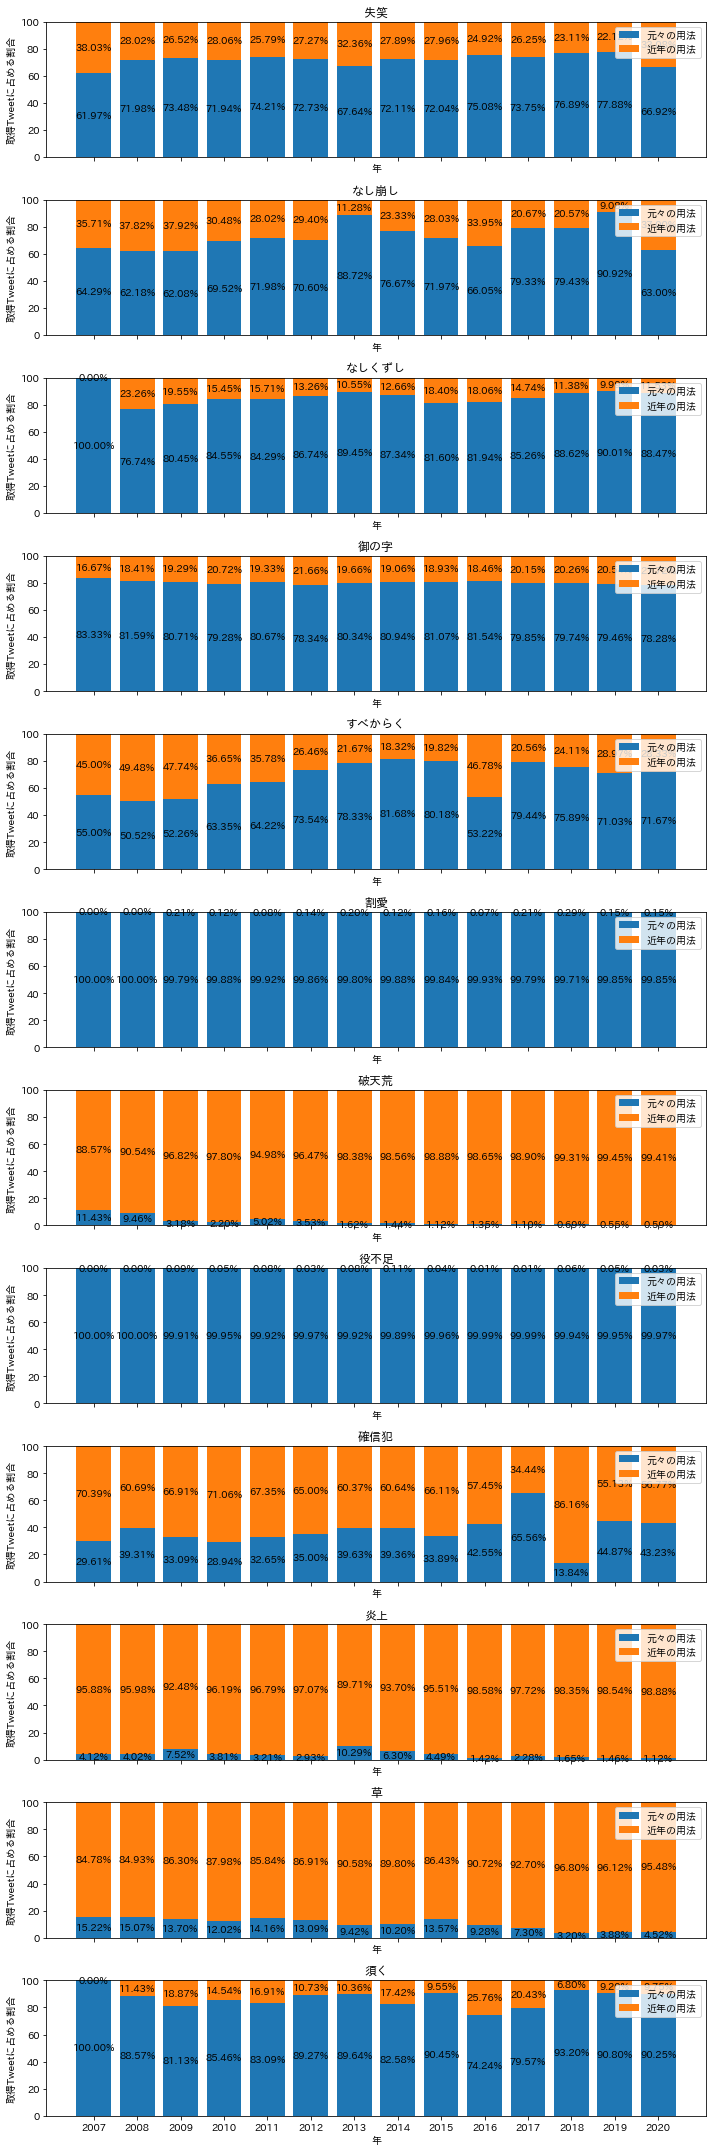

In [ ]:
import japanize_matplotlib
import matplotlib.pyplot as plt

with open(base_dir + "result_data.json") as f:
    result_data = json.load(f)
fig, ax = plt.subplots(
    len(result_data["data"]),
    1,
    figsize=(10, 30),
    sharex=True,
    sharey=True,
    tight_layout=True,
)
for index, word in enumerate(result_data["data"]):
    print("-------------- " + word + " --------------")
    item = result_data["data"][word]
    ax[index].set_title(word)
    ax[index].set_xticks(range(2007, 2021))
    ax[index].set_xlabel("年")
    ax[index].set_ylabel("取得Tweetに占める割合")
    bar1 = ax[index].bar(
        range(2007, 2021),
        [item[y]["old"] / item[y]["total"]*100 for y in item],
        label="元々の用法",
    )
    ax[index].bar_label(bar1, label_type="center", fmt="%.2f%%")
    bar2 = ax[index].bar(
        range(2007, 2021),
        [item[y]["new"] / item[y]["total"]*100 for y in item],
        bottom=[item[y]["old"] / item[y]["total"]*100 for y in item],
        label="近年の用法",
    )
    ax[index].bar_label(bar2, label_type="center", fmt="%.2f%%")
    ax[index].legend(loc=1)
    for year in item:
        i = item[year]
        print(
            str(year)
            + "　old: {:.2%} / new: {:.2%}".format(
                i["old"] / i["total"], i["new"] / i["total"]
            )
        )
plt.savefig(base_dir + "result-12-13.eps")
plt.show()

### 保存後処理

In [ ]:
# formatter
!pip install -q black[jupyter]
!black "/content/drive/MyDrive/Colab Notebooks/bertClustering.ipynb"

### その他

In [ ]:
from tensorflow.python.client import device_lib
import tensorflow as tf
from psutil import virtual_memory

# RAMのサイズをcheck
ram_gb = virtual_memory().total / 1e9
print("Your runtime has {:.1f} gigabytes of available RAM\n".format(ram_gb))

if ram_gb < 20:
    print("Not using a high-RAM runtime")
else:
    print("You are using a high-RAM runtime!")
# GPUの数をcheck
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
# Check GPU recognized
print(device_lib.list_local_devices())